In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from gptools.stan import compile_model

import cmdstanpy
cmdstanpy.install_cmdstan()


/root/.cache/pypoetry/virtualenvs/stan-env-Zdpe4cqc-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CmdStan install directory: /root/.cmdstan
CmdStan version 2.33.1 already installed
Test model compilation


True

In [2]:
# !pip install nest_asyncio

In [3]:
import nest_asyncio
nest_asyncio.apply()

In [4]:
df = pd.read_csv('quality_nj2.csv')
#df = df[(df['YEAR_CODE'] == 1) & (df['MONTH_CODE'] == 1)]
from sklearn.preprocessing import LabelEncoder
encoder1, encoder2, encoder3 = LabelEncoder(), LabelEncoder(), LabelEncoder()
df['RATING_EVENT_CODE'] = encoder1.fit_transform(df['RATING_EVENT'])
df['ENTRY_NAME_CODE'] = encoder2.fit_transform(df['ENTRY_NAME'])
df['PLT_ID_CODE'] = encoder3.fit_transform(df['PLT_ID'])
df['PLT_ID_CODE'] = encoder3.fit_transform(df['PLT_ID'])
# The categorical variables are now encoded with numerical values

In [5]:
plt_coords = df.groupby('PLT_ID_CODE')[['ROW','COL']].mean()
from scipy.spatial.distance import cdist
coords = np.array([plt_coords['ROW'].values, plt_coords['COL'].values])
distances = cdist(coords.T,coords.T, metric='euclidean')
distances
# The 'distance_matrix' is now an n x n NumPy array containing the Euclidean distances

array([[ 0.        ,  1.        ,  2.        , ..., 17.2626765 ,
        17.11724277, 17.02938637],
       [ 1.        ,  0.        ,  1.        , ..., 17.11724277,
        17.02938637, 17.        ],
       [ 2.        ,  1.        ,  0.        , ..., 17.02938637,
        17.        , 17.02938637],
       ...,
       [17.2626765 , 17.11724277, 17.02938637, ...,  0.        ,
         1.        ,  2.        ],
       [17.11724277, 17.02938637, 17.        , ...,  1.        ,
         0.        ,  1.        ],
       [17.02938637, 17.        , 17.02938637, ...,  2.        ,
         1.        ,  0.        ]])

In [6]:
plt_coords['ROW'].astype(int)

PLT_ID_CODE
0       1
1       1
2       1
3       1
4       1
       ..
262    18
263    18
264    18
265    18
266    18
Name: ROW, Length: 267, dtype: int64

In [10]:
import stan
#fourier model
padding = 5 # adjustable
num_rows = 18
num_cols = 15
stan_data_fourier = {"N": len(df["QUALITY"]),
             "I":len(df['RATING_EVENT'].unique()),
             "J":len(df['ENTRY_NAME'].unique()),
             "P":len(df['PLT_ID'].unique()),
             "M": 9,
             "ii": df["RATING_EVENT_CODE"].values+1,
             "jj": df["ENTRY_NAME_CODE"].values+1,
             "pp": df["PLT_ID_CODE"].values+1,
             "y": df["QUALITY"].values,
             "DIST": distances,
              # new values
             "num_rows": num_rows,
             "num_cols": num_cols,
             "num_rows_padded": num_rows + padding,
             "num_cols_padded": num_cols + padding,
             "plot_row" : plt_coords["ROW"].astype(int),
             "plot_col" : plt_coords["COL"].astype(int)
              }
fourier_model = compile_model(stan_file="simple_fourier_model_2.stan", force_compile=True)

22:10:46 - cmdstanpy - WARNING - CmdStanModel(compile=...) is deprecated and will be removed in the next major version. The constructor will always ensure a model has a compiled executable.
If you wish to force recompilation, use force_compile=True instead.
22:10:46 - cmdstanpy - INFO - compiling stan file /home/hok/oxb_econ/stan-env/stan_env/simple_fourier_model_2.stan to exe file /home/hok/oxb_econ/stan-env/stan_env/simple_fourier_model_2
22:11:13 - cmdstanpy - INFO - compiled model executable: /home/hok/oxb_econ/stan-env/stan_env/simple_fourier_model_2


In [11]:
#fit = adv_model.sample(num_chains=1, num_samples=200)
fit = fourier_model.sample(stan_data_fourier)

22:11:13 - cmdstanpy - INFO - CmdStan start processing




chain 1 |                                                                                                 | 00:00 Status




chain 2 |                                                                                                 | 00:00 Status





chain 3 |                                                                                                 | 00:00 Status






chain 4 |                                                                                                 | 00:00 Status




chain 2 |████▍                                                                                            | 00:00 Status



chain 1 |████▍                                                                                            | 00:00 Status





chain 3 |████▍                                                                                            | 00:00 Status






chain 4 |████▍                                               

KeyboardInterrupt: 

In [ ]:
fit.to_frame()

In [ ]:
import stan
basic_model = """
data {
  int<lower=1> N;                // total number of responses
  int<lower=1> y[N];             // ratings of responses
}
parameters {
  real mu;
  real<lower=0> sigma;
}
model {
  mu ~ normal(4, 16);
  sigma ~ normal(4, 16);
  y ~ normal(mu, sigma);
}
"""
stan_data = {"N": len(df["QUALITY"]), "y": df["QUALITY"].values}
posterior = stan.build(basic_model, data=stan_data, random_seed=1)

In [ ]:
fit = posterior.sample(num_chains=1, num_samples=1000)
fit

Sampling:   0%
Sampling:   5% (100/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 0.000172 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.72 seconds.
  Adjust your expectations accordingly!


<stan.Fit>
Parameters:
    mu: ()
    sigma: ()
Draws: 1000

In [ ]:
sig = fit["sigma"]
sig

array([[1.78406395, 1.78935272, 1.77437709, 1.77437709, 1.77677112,
        1.80654566, 1.80238584, 1.79625201, 1.79776993, 1.79271678,
        1.80556215, 1.77898738, 1.8157829 , 1.80333262, 1.78127764,
        1.8068461 , 1.80547109, 1.81243668, 1.77065977, 1.81524014,
        1.81485281, 1.81470421, 1.80655535, 1.80725705, 1.79447598,
        1.79673825, 1.79998584, 1.79748665, 1.79118649, 1.80495204,
        1.7954601 , 1.78271622, 1.79900933, 1.80434378, 1.79840456,
        1.78403376, 1.79866586, 1.79166855, 1.79762889, 1.80006632,
        1.79497799, 1.78865739, 1.82626012, 1.8280259 , 1.8228555 ,
        1.82062178, 1.78129477, 1.81211521, 1.78371441, 1.80185102,
        1.80113306, 1.80123327, 1.80713305, 1.79274847, 1.77951648,
        1.78826336, 1.80895497, 1.79449971, 1.79812841, 1.79548498,
        1.80196263, 1.7927378 , 1.79646969, 1.79582602, 1.79801889,
        1.78902823, 1.81212496, 1.78463878, 1.80184308, 1.7876547 ,
        1.79954826, 1.7838968 , 1.79543077, 1.77

In [ ]:
dff = fit.to_frame()
dff

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma
draws,,,,,,,,,
0,-10438.153172,0.992174,0.792383,3.0,7.0,0.0,10439.325465,4.954696,1.784064
1,-10437.445173,1.000000,0.792383,1.0,1.0,0.0,10438.275555,4.951560,1.789353
2,-10437.729875,0.941067,0.792383,3.0,7.0,0.0,10439.794838,4.883075,1.774377
3,-10437.729875,0.752060,0.792383,1.0,1.0,0.0,10439.378973,4.883075,1.774377
4,-10436.193473,0.933388,0.792383,2.0,3.0,0.0,10438.860447,4.905803,1.776771
...,...,...,...,...,...,...,...,...,...
995,-10436.261856,0.994008,0.792383,2.0,3.0,0.0,10438.206606,4.915920,1.817136
996,-10435.411784,0.969496,0.792383,2.0,3.0,0.0,10436.904935,4.899175,1.788488
997,-10435.481975,0.990133,0.792383,3.0,7.0,0.0,10435.859267,4.928984,1.790956


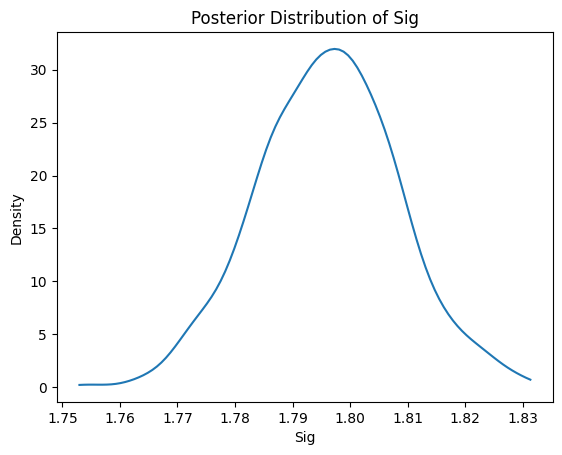

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Plot posterior distribution

# Compute kernel density estimate
kde = stats.gaussian_kde(sig)

# Generate x-values for the density plot
x = np.linspace(sig.min(), sig.max(), 100)

# Plot density
plt.plot(x, kde(x))
plt.xlabel('Sig')
plt.ylabel('Density')
plt.title('Posterior Distribution of Sig')
plt.show()

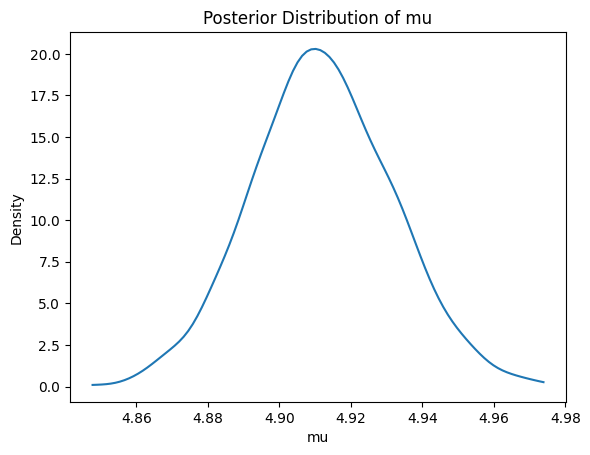

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Plot posterior distribution
mu = fit["mu"]
# Compute kernel density estimate
kde = stats.gaussian_kde(mu)

# Generate x-values for the density plot
x = np.linspace(mu.min(), mu.max(), 100)

# Plot density
plt.plot(x, kde(x))
plt.xlabel('mu')
plt.ylabel('Density')
plt.title('Posterior Distribution of mu')
plt.show()